In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
directory = "./Logs/"
save_path = "./Saved/"

from load_logs import *
from evaluation import *
from features import *
from visualize import *

logs, log_labels = read_logs_and_labels("./Saved/logs.txt", "./Saved/labels.txt")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import os
import pickle
import sys
import random
import hdbscan
import itertools

from bregclus.models import BregmanHard
from bregclus.divergences import euclidean
from multiprocessing import get_context
from sklearn.cluster import Birch
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_samples
from sklearn.metrics.cluster import contingency_matrix
from scipy import sparse
from multiprocessing import Pool
from math import sqrt
from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans

In [3]:
#Time to define necessary functions
#Since this is based on a knn idea we will need to calculate euclidean distance

In [4]:
#Nearest neighbour - gets x number of nearest nodes
def nearest(x, y_row, neighbors, labels): #specify number of neighbours to return
    distances = np.linalg.norm(x - y_row, axis=1)#numpy array of distances
    size, y = np.shape(x)
    itera = np.arange(0,size).reshape(-1,1)
    for i in range(len(labels)):
        distances = np.c_[distances,labels[i]]
    distances = np.c_[distances,itera]
    distances = distances[np.argsort(distances[:, 0])]
    neighborsList, neighborsLabels, iteraList = list(), list(), list()
    for i in range(neighbors): #27093
        neighborsList.append(distances[i][0])
        neighborsLabels.append(distances[i][1:len(distances[i])-1])
        iteraList.append(distances[i][len(distances[i])-1])
    return neighborsList,neighborsLabels,iteraList
    
def lookUp(labels, lookup, which):
    arr = np.array(labels)
    x,y = np.shape(arr)
    indices = np.argwhere(arr[which] == lookup)
    return indices
def firstTrue(boolArr):
    for i in range(len(boolArr)):
        if boolArr[i] == True:
            return i
def recluster(x,y,itera,labels,X): #Recluster based on silhouette coefficient (i.e whichever node here has a higher coefficient)
    acL = labels[0]
    acL[itera] = x
    acSilVal = silhouette_samples(X, acL)
    hdbL = labels[0]
    hdbL[itera] = y
    hdbSilVal = silhouette_samples(X, hdbL)
    if hdbSilVal[itera] > acSilVal[itera]:
        return y
    else:
        return x
def isEqual(x,y):
    if x == y:
        return True
    else:
        return False

#Current and nearest are same cluster then true otherwise false
def checkClus(x,y):#check all nodes are of the same array
    ret = list()
    for i in range(3):
        boolArr = list(map(isEqual, x, y[i]))
        ret.append(boolArr)
    return ret
    
def equalRow(boolArr, rowNum):
    for i in range(5):
        if boolArr[i][rowNum] == False:
            return False
    return True

def counting(boolArr,rowNum):
    count = 0
    indices = list()
    for x in range(3):
        if boolArr[x][rowNum] == True:
            count = count+1
        else:
            indices.append(x)
    return count,indices

def vote(a,h):
    if a < 3 and h < 3: #if majority of nodes are in another cluster
        return False
    else:
        return True

def consensus(x,y,labels,silVal,itera,acLookUpList,hdbLookUpList,X): #form boolean array from checkClus, if majority are true then the node should be in the cluster, otherwise not
    #x is the labels of our node
    #y is a 2d array where we have our k labels ac labels and our hdb labels (IN THAT ORDER) of the neighbours
    #labels is our total labels
    #silVal is our silhouette values (All silhouette values)
    #itera is the corresponding row number in the array to the 6 nodes (node A and its 5 nearest neighbours)
    #Then we have our two lookup lists where index corresponds to that algos cluster, and the value is the k means equivalent
    
    #First step - translate the lists
    klabels = [x[0],y[0][0],y[1][0],y[2][0],y[3][0],y[4][0]]
    acLabels = [acLookUpList[int(y[0][1])],acLookUpList[int(y[1][1])],acLookUpList[int(y[2][1])],acLookUpList[int(y[3][1])],acLookUpList[int(y[4][1])]]
    hdbLabels = [hdbLookUpList[int(y[0][2])],hdbLookUpList[int(y[1][2])],hdbLookUpList[int(y[2][2])],hdbLookUpList[int(y[3][2])],hdbLookUpList[int(y[4][2])]]    
    #Operating with the assumption that x is in the same cluster for each node
    #Second step - determine if majority of nodes are in the same array as that of x in the k means algorithm
    #As we have 5 neighbours anything less than 3 in the same cluster is a minority - thus we recluster here
    ac = max(set(acLabels), key=list(acLabels).count)
    hdb = max(set(hdbLabels), key=list(hdbLabels).count)
    noRecluster = (ac == hdb == klabels[0])               
    
    #Third step - if we are to recluster, determine on the cluster from ac and hdb
    if (noRecluster == False):#2 cases here
        #Case 1: ac and hdb agree on the cluster to place x in
        if (ac == hdb):
            print("replacing "+ str(x[0]) +" with "+ str(ac) + " at "+str(itera[0]))
            return noRecluster, ac #Return the agreed upon value
        #Case 2: They disagree on the cluster to place thus we recluster based on the silhouette score
        #We will calculate whichever has a higher silval at itera[0]
        elif ac == x[0] or hdb == x[0]:
            return False, x[0]
        else:
            print("Silhouete - Fail")
            return noRecluster, recluster(ac,hdb,itera[0],labels,X)                    
    #If ac and hdb cannot agree we rely on silhouette values to determine a better cluster for node x
    else: #If the most common cluster assignment of neighbours aligns with x
            return True, klabels[0]
    


def comprehension(X,labels,x,itera,silVal,acLookUpList,hdbLookUpList):
    silValed = silVal
    Xed = X
    lb = list()
    lb.append(labels[0][itera])
    lb.append(labels[1][itera])
    lb.append(labels[2][itera])
    
    labelsed = (np.reshape(np.array(labels),(-1,3))).tolist()
    labs = labels
    it = list()
    X = np.delete(X,itera, axis = 0)
    labels = np.delete(labels,itera, axis = 1)
    silValed = np.delete(silVal,itera, axis = 0)
    near, tempLab,inds = nearest(X, x, 5, labels)
    it.append(itera)
    it.extend(inds)
    print(it)
    boolArr1,res1 = consensus(lb,tempLab,labs,silVal,it,acLookUpList,hdbLookUpList,Xed)
    if boolArr1 == True:
        return int(res1) #need to sort this out such that we assign a valid cluster number
    else: #recluster somehow
        print("Failed - reclustering")
        return int(res1)


In [5]:
#Addresses label correspondence issue - By translation

def translateLabels(masterList, listToConvert):    
    contMatrix = contingency_matrix(listToConvert,masterList)
    labelTranslater = np.argmax(contMatrix, axis=1)
    return labelTranslater

False


In [56]:
def takeConsensus(X, labels,silVal):
    x,y = np.shape(X)
    i = list(range(0,x))
    tasks = [*zip(itertools.repeat(X,x),itertools.repeat(labels,x), X,i,itertools.repeat(silVal,x))]
    print("running consensus")
    #p = Pool(6)#Multiprocessing to speed up run time
    with Pool() as p:
    #conList = [comprehension(X, labels, x) for x in X]
        conList = p.starmap(comprehension, tasks)
    #conList = starmap(comprehension, tasks)
    #for i in range(len(X)):
        #boolArr = list()
        #near, tempLab = nearest(X_, X[i], 3, labels) #do not repeat values in proximity
        #X_ = np.delete(X, i, axis = 0) #This will exclude the current node from our next nearest calculations
        #boolArr1 = checkClus(tempLab[0],tempLab[1])
       # boolArr2 = checkClus(tempLab[0],tempLab[2])
        #if consensus(boolArr1):
          #  conList.append(tempLab[0][0]) #need to sort this out such that we assign a valid cluster number
        #elif consensus(boolArr2): #here we check its second nearest neighbor before reclustering
         #   conList.append(tempLab[1][0])
       # else: #recluster somehow
           # conList.append(tempLab[0][0])
        #print(conList)
    return conList

In [8]:
labels_ = log_labels
            
X = get_features(logs, 2, 70)
X = X.toarray()

idxs = np.where(np.all(X == 0, axis=1))

X = np.delete(X, idxs, axis=0)
labels_ = np.delete(labels_, idxs)
## K Means Labels
kmeans = KMeans(init="k-means++", n_clusters=10,random_state=0).fit(X)
kLabels = kmeans.labels_

## DBSCAN Labels
#DBmodel = DBSCAN(eps=0.4,min_samples=200,algorithm="auto",metric="cosine")
#DBmodel.fit(X)
#dbLabels = DBmodel.labels_

## Birch Label
#birchmodel = Birch(n_clusters=10, branching_factor=100, threshold=0.5, compute_labels=True)
#Y = birchmodel.fit_transform(X)
#birchLabels = birchmodel.labels_

#HDBScan Labels
model = hdbscan.HDBSCAN(min_cluster_size=500,min_samples=100,cluster_selection_epsilon=0.5,
                                        metric="euclidean",algorithm='best')
model.fit(X)
hdbLabels = model.labels_


In [43]:
#Bregman Labels
#bhc = BregmanHard(n_clusters=10, divergence=euclidean)
#bhc.fit(X)
#bLabels = bhc.predict(X)
#print(np.shape(np.nonzero(bLabels)))

(1, 22985)


In [9]:
from sklearn.cluster import AgglomerativeClustering

model = AgglomerativeClustering(n_clusters = 10)
acLabels = model.fit_predict(X)
acresults = evaluate_clustering('Agglomerative Bigram Clustering', X, labels_, acLabels)
print(acresults)

['Agglomerative Bigram Clustering', '0.79', '0.85', '0.82', '0.60', '0.82', '0.66']


In [10]:
silVal = silhouette_samples(X, kLabels)

In [11]:
hdbLabels = hdbLabels + 1 #This will be important for creating our look up list

In [12]:
#testing
labels, acLookupList, hdbLookUpList = list(), list(),list()
labels.append(kLabels)
labels.append(acLabels)
labels.append(hdbLabels)
acLookUpList = translateLabels(kLabels,acLabels)#had better results than bregmans
hdbLookUpList = translateLabels(kLabels,hdbLabels)

print(list(set(hdbLabels)))
print(hdbLookUpList)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
[6 2 6 4 3 3 3 9 6 0 7 5 5 1 6]


2


In [360]:
print(np.shape(labels))
print(np.shape(X))

(3, 27093)
(27093, 1832)


In [44]:
x,y,z = nearest(X, X[8627], 6, labels)
lb = list()
lb.append(labels[0][8627])
lb.append(labels[1][8627])
lb.append(labels[2][8627])
lb.append(labels[3][8627])
lb.append(labels[4][8627])
boolArr = checkClus(lb,y[1:6])
print(y[1:6])
equalRow(boolArr, 0)

[array([2., 1., 7., 0., 7.]), array([2., 1., 7., 0., 7.]), array([2., 1., 7., 0., 7.]), array([2., 1., 7., 0., 7.]), array([2., 1., 7., 0., 7.])]


True

[ 9.94987437 12.24744871  2.82842712 ...  9.94987437  7.93725393
  4.79583152]


In [ ]:
itertools.repeat(silVal, x)

In [ ]:
print(np.shape(silVal))
print(np.shape(X))
print(np.shape(labels))

In [15]:
import worker
if __name__ == '__main__':
    #Figure out better replacement method maybe
    x,y = np.shape(X)
    i = list(range(0,x))
    tasks = [*zip(itertools.repeat(X, x),itertools.repeat(labels, x), X, i, itertools.repeat(silVal, x), itertools.repeat(acLookUpList, x), itertools.repeat(hdbLookUpList, x))]
    p = Pool(4)
    cLabels = p.starmap(worker.comprehension, tasks)
    print(cLabels)
    p.close()
    p.join()

[6, 6, 3, 4, 1, 5, 3, 6, 5, 4, 1, 1, 4, 6, 3, 1, 5, 5, 9, 1, 9, 4, 2, 2, 6, 1, 4, 1, 1, 5, 1, 6, 9, 4, 3, 4, 1, 4, 6, 1, 2, 1, 0, 3, 3, 6, 1, 1, 0, 5, 4, 1, 1, 0, 6, 1, 6, 2, 1, 1, 5, 6, 2, 5, 9, 5, 2, 1, 2, 0, 6, 3, 6, 1, 3, 1, 4, 1, 5, 6, 6, 1, 5, 1, 6, 4, 1, 1, 1, 6, 3, 3, 3, 2, 9, 1, 1, 6, 0, 1, 7, 6, 6, 9, 6, 5, 2, 1, 1, 3, 2, 7, 2, 1, 3, 6, 1, 4, 6, 6, 4, 1, 4, 7, 6, 1, 3, 5, 7, 4, 1, 5, 6, 3, 4, 5, 4, 6, 5, 3, 1, 1, 1, 6, 5, 4, 1, 1, 1, 2, 6, 1, 5, 1, 9, 5, 4, 1, 0, 5, 1, 4, 1, 7, 1, 4, 9, 1, 3, 9, 6, 5, 9, 3, 1, 6, 1, 6, 6, 5, 2, 3, 1, 4, 9, 1, 3, 2, 6, 1, 0, 9, 6, 5, 3, 2, 3, 5, 6, 3, 5, 1, 0, 1, 5, 6, 6, 7, 1, 3, 1, 1, 5, 5, 5, 1, 1, 2, 7, 9, 1, 6, 5, 1, 0, 4, 2, 2, 9, 6, 3, 4, 1, 1, 1, 9, 6, 6, 5, 4, 1, 1, 7, 1, 3, 1, 4, 1, 2, 5, 5, 3, 3, 6, 1, 5, 6, 5, 6, 2, 0, 1, 5, 9, 2, 2, 3, 2, 6, 2, 1, 9, 1, 4, 2, 1, 3, 5, 1, 3, 1, 7, 6, 4, 5, 4, 5, 3, 4, 2, 6, 1, 0, 0, 7, 6, 7, 9, 5, 3, 4, 1, 4, 5, 9, 1, 7, 1, 6, 3, 6, 9, 6, 6, 1, 9, 1, 6, 6, 5, 3, 1, 1, 4, 1, 6, 1, 4, 4, 4, 2, 1, 2, 

In [16]:
print(kLabels[11765])
print(cLabels[11765])
print(kLabels - cLabels)
print(np.shape(np.nonzero(kLabels - cLabels)))
#12 nodes changed with db, hdb (in order) - hdb is a better option
#11 nodes changed with hdb, birch
#10 nodes changed with hdc,ac,birch and db

8
1
[0 0 0 ... 0 0 0]
(1, 2962)


In [19]:
print(set(cLabels) - set(kLabels))

set()


In [359]:
print(recluster(2,5,12,labels,X)) #replacing 8 with 1 2915 (WEIRD HOW IT IS ALWAYS 8 WITH 1) GET TO BOTTOM OF THIS

2


In [ ]:
#print((np.reshape(np.array(labels),(-1,3))).tolist())
x = list()
x.append(labels[0][3144])
x.append(labels[1][3144])
x.append(labels[2][3144])
y = list()
y.append(labels[0][11981])
y.append(labels[1][11981])
y.append(labels[2][11981])
recluster(labels[0][3144],labels[0][11981],silVal, [3144, 11981.0])

In [14]:
x = comprehension(X,labels,X[5238],5238,silVal,acLookUpList,hdbLookUpList) #did not fully pass

print(x)
#[3590.0, 1393.0]
#Succesful recluster
#did not fully pass
#[1002.0, 19211.0]
#Succesful recluster
#failed!
#[4676.0, 11270.0]
#Succesful recluster
#Failed - reclustering
#did not fully pass
#[3144.0, 1403.0]
#Succesful recluster
#did not fully pass
#[8627.0, 24408.0]
#fixed issue where passing wrong label list
#print(str(labels[0][26903]) + " labels")
#recluster(4,[[9,6,5],[9,5,5],[9,12,5],[3,5,5],[5,5,5]],silVal,[27092, 18666.0, 7632.0, 12131.0, 16373.0, 1656.0])

[5238, 19017.0, 22014.0, 13292.0, 24220.0, 13351.0]
Failed - reclustering
1


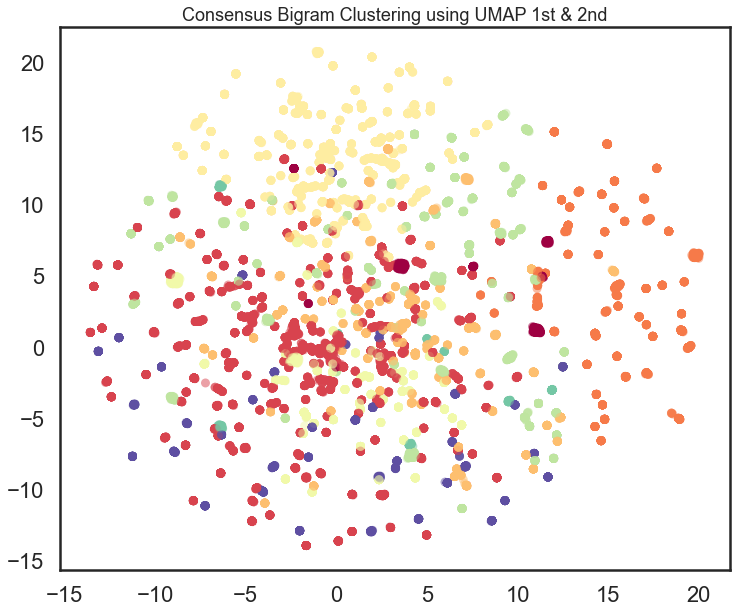

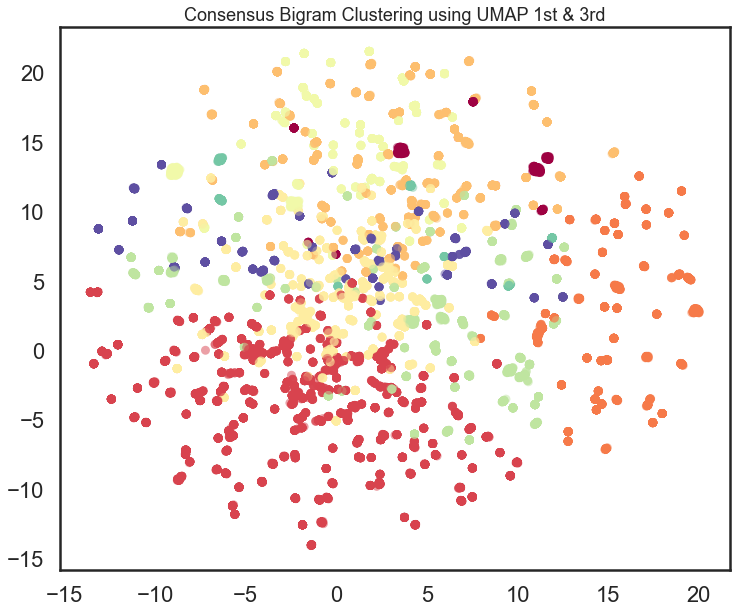

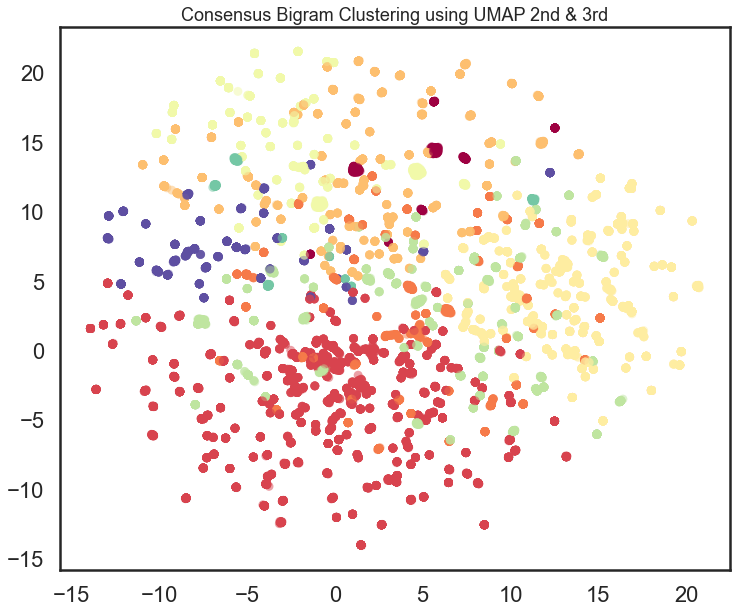

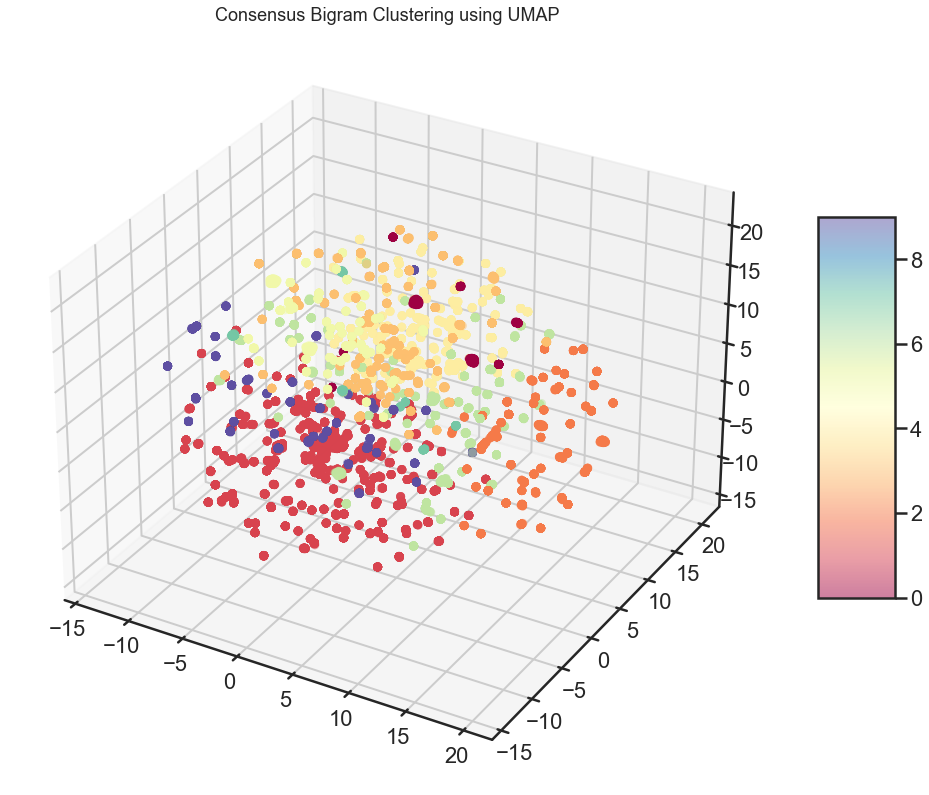

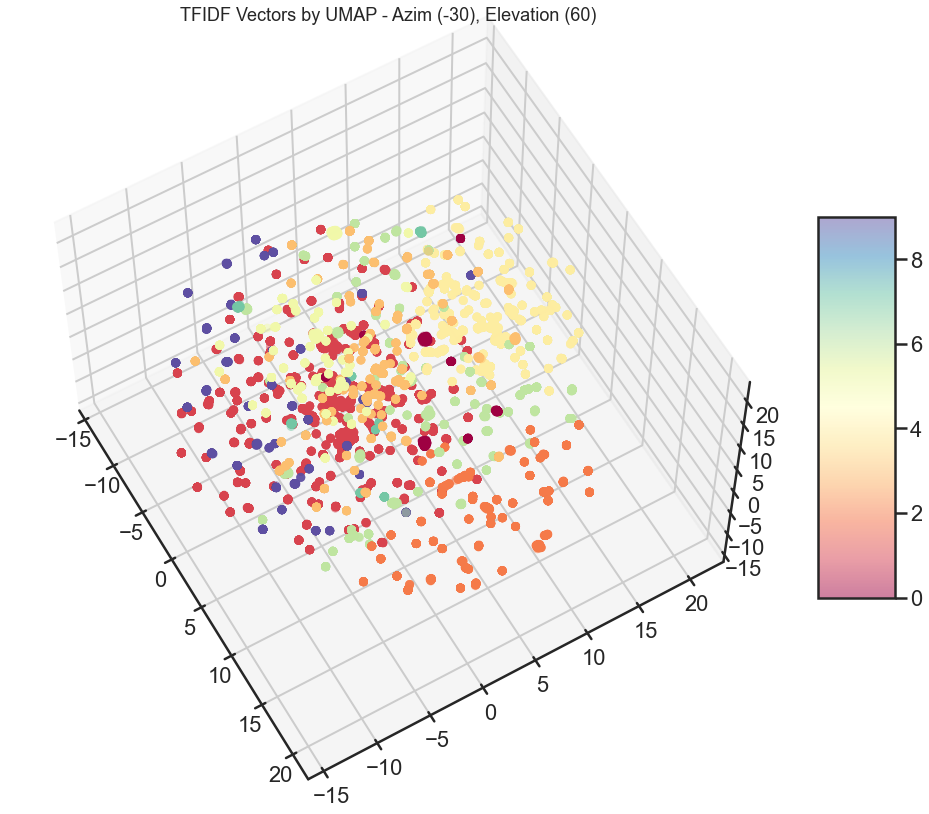

In [17]:
plot_clusters("Consensus Bigram Clustering using UMAP", X, cLabels)

In [18]:
results = evaluate_clustering('Consensus Bigram Clustering', X, labels_, cLabels)
print(results)

['Consensus Bigram Clustering', '0.81', '0.92', '0.86', '0.68', '0.86', '0.73']


In [6]:
labels_ = log_labels
            
X = get_features(logs, 3, 90)
X = X.toarray()

idxs = np.where(np.all(X == 0, axis=1))

X = np.delete(X, idxs, axis=0)
labels_ = np.delete(labels_, idxs)
## K Means Labels
kmeans = KMeans(init="k-means++", n_clusters=10,random_state=0).fit(X)
kLabels = kmeans.labels_

## DBSCAN Labels
#DBmodel = DBSCAN(eps=0.4,min_samples=200,algorithm="auto",metric="cosine")
#DBmodel.fit(X)
#dbLabels = DBmodel.labels_

## Birch Label
#birchmodel = Birch(n_clusters=10, branching_factor=100, threshold=0.5, compute_labels=True)
#Y = birchmodel.fit_transform(X)
#birchLabels = birchmodel.labels_

#HDBScan Labels
model = hdbscan.HDBSCAN(min_cluster_size=500,min_samples=100,cluster_selection_epsilon=0.5,
                                        metric="euclidean",algorithm='best')
model.fit(X)
hdbLabels = model.labels_

In [7]:
from sklearn.cluster import AgglomerativeClustering

model = AgglomerativeClustering(n_clusters = 10)
acLabels = model.fit_predict(X)
acresults = evaluate_clustering('Agglomerative Trigram Clustering', X, labels_, acLabels)
print(acresults)

['Agglomerative Trigram Clustering', '0.80', '0.88', '0.84', '0.66', '0.84', '0.71']


In [8]:
hdbLabels = hdbLabels + 1 #This will be important for creating our look up list
silVal = silhouette_samples(X, kLabels)

In [9]:
labels, acLookupList, hdbLookUpList = list(), list(),list()
labels.append(kLabels)
labels.append(acLabels)
labels.append(hdbLabels)
acLookUpList = translateLabels(kLabels,acLabels)#had better results than bregmans
hdbLookUpList = translateLabels(kLabels,hdbLabels)

In [11]:
print(np.shape(labels))
print(np.shape(X))
print(np.shape(acLabels))
print(np.shape(hdbLabels))

(3, 27044)
(27044, 1968)
(27044,)
(27044,)


In [12]:
import worker
if __name__ == '__main__':
    #Figure out better replacement method maybe
    x,y = np.shape(X)
    i = list(range(0,x))
    tasks = [*zip(itertools.repeat(X, x),itertools.repeat(labels, x), X, i, itertools.repeat(silVal, x), itertools.repeat(acLookUpList, x), itertools.repeat(hdbLookUpList, x))]
    p = Pool(4)
    ctLabels = p.starmap(worker.comprehension, tasks)
    print(cLabels)
    p.close()
    p.join()

NameError: name 'cLabels' is not defined

In [14]:
print(ctLabels)

[7, 7, 6, 1, 2, 5, 6, 7, 5, 1, 2, 2, 1, 7, 6, 2, 8, 5, 3, 2, 3, 1, 0, 0, 7, 2, 1, 2, 2, 5, 2, 7, 3, 1, 6, 1, 2, 1, 7, 2, 0, 2, 9, 6, 6, 7, 2, 2, 9, 5, 1, 2, 2, 9, 7, 2, 7, 0, 2, 2, 5, 7, 0, 8, 3, 8, 0, 2, 0, 0, 7, 6, 7, 2, 6, 2, 1, 2, 8, 7, 7, 2, 5, 2, 1, 2, 2, 2, 7, 6, 6, 6, 0, 3, 2, 2, 7, 9, 2, 5, 7, 7, 3, 7, 8, 0, 2, 2, 6, 0, 5, 0, 2, 6, 2, 1, 7, 7, 1, 2, 1, 5, 7, 2, 6, 5, 8, 1, 2, 5, 7, 6, 1, 8, 1, 7, 5, 6, 2, 2, 2, 7, 8, 1, 2, 2, 2, 0, 7, 2, 5, 2, 3, 8, 1, 2, 9, 5, 2, 1, 2, 5, 2, 1, 3, 2, 6, 3, 7, 5, 3, 6, 2, 7, 2, 7, 7, 5, 0, 6, 2, 1, 3, 2, 6, 0, 7, 2, 9, 3, 7, 8, 6, 0, 6, 5, 7, 6, 5, 2, 9, 2, 5, 7, 7, 8, 2, 6, 2, 2, 5, 5, 8, 2, 2, 0, 5, 3, 2, 7, 5, 2, 9, 1, 0, 0, 3, 7, 6, 1, 2, 2, 2, 3, 7, 7, 5, 1, 2, 2, 5, 2, 6, 2, 1, 2, 0, 5, 5, 6, 6, 7, 2, 5, 7, 5, 7, 0, 9, 2, 8, 3, 0, 0, 6, 0, 7, 0, 2, 3, 2, 1, 0, 2, 6, 5, 2, 6, 2, 5, 7, 1, 5, 1, 5, 6, 1, 0, 7, 2, 9, 9, 5, 7, 5, 3, 8, 6, 1, 2, 1, 5, 3, 2, 8, 2, 7, 6, 7, 3, 7, 7, 2, 3, 2, 7, 7, 5, 6, 2, 2, 1, 2, 7, 2, 1, 1, 1, 0, 2, 0, 7, 7, 

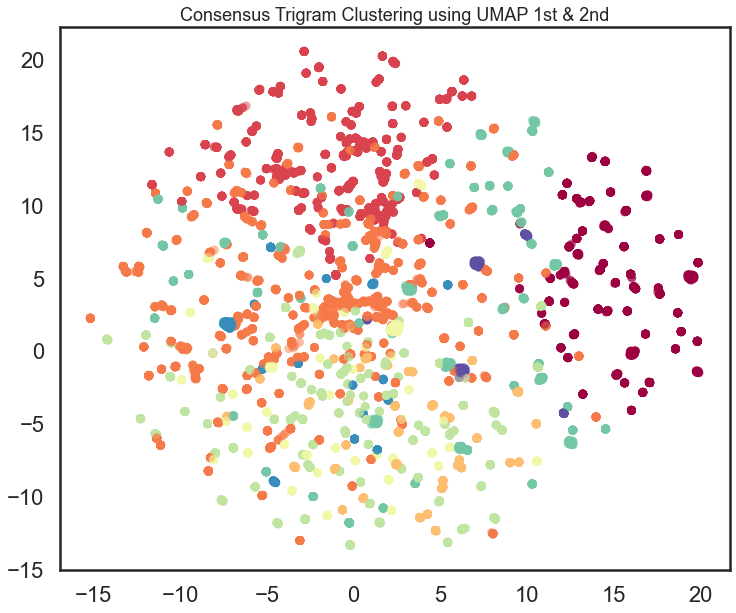

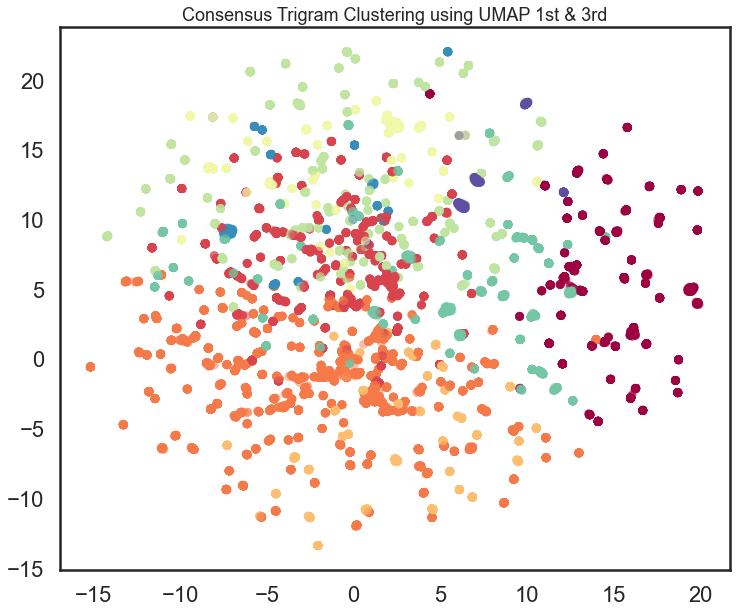

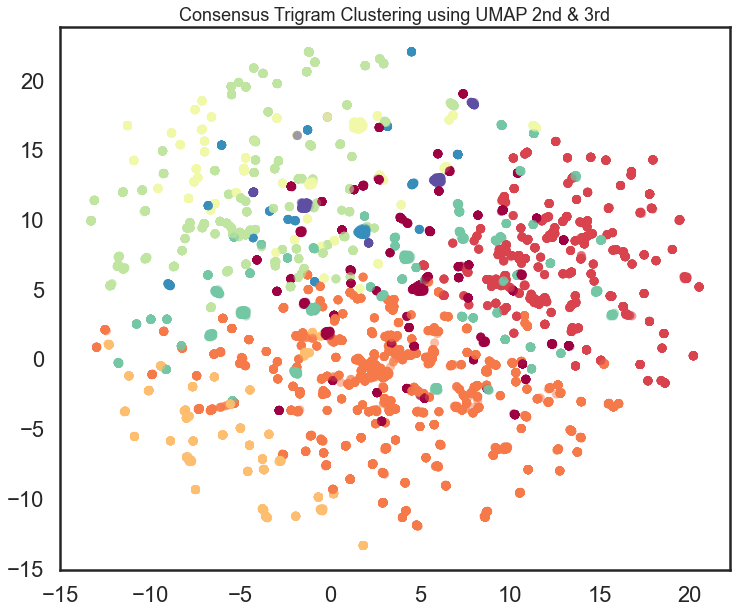

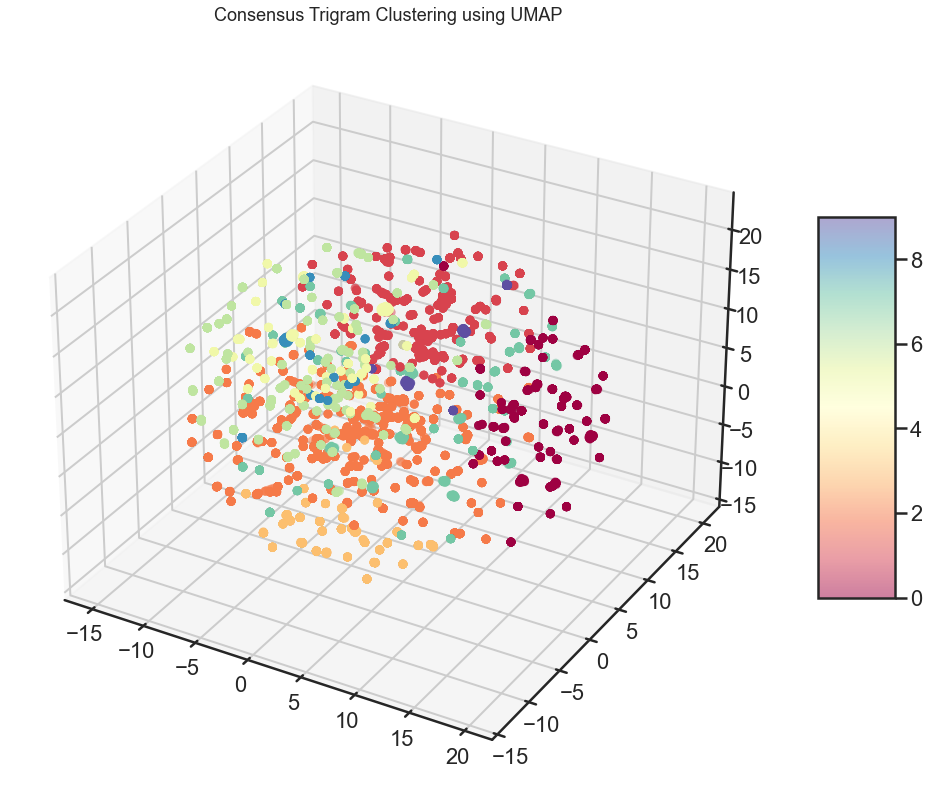

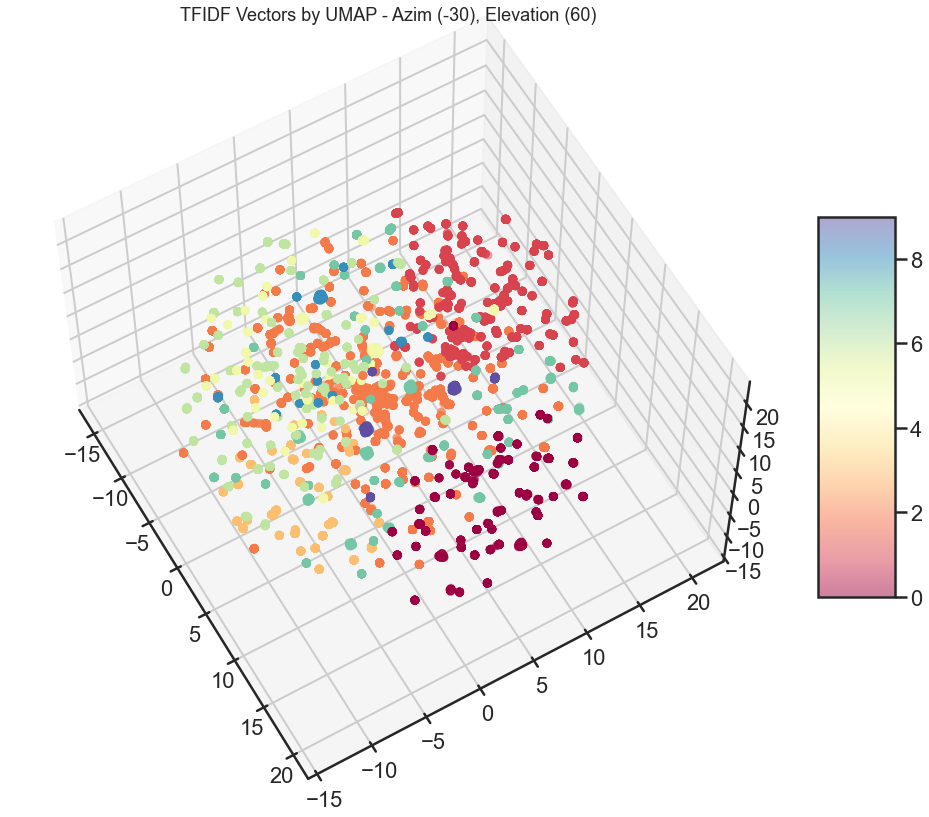

In [15]:
plot_clusters("Consensus Trigram Clustering using UMAP", X, ctLabels)

In [16]:
results = evaluate_clustering('Consensus Trigram Clustering', X, labels_, ctLabels)
print(results)

['Consensus Trigram Clustering', '0.81', '0.91', '0.86', '0.68', '0.86', '0.73']


In [17]:
print(np.shape(np.nonzero(kLabels - ctLabels)))

(1, 1175)
